# **Setup**

In [ ]:
pip install stockstats

In [ ]:
import pandas_datareader.data as web
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np
import seaborn as sns
from stockstats import StockDataFrame as Sdf
import scipy 
import pywt
import math
from pandas.tseries.offsets import CustomBusinessDay, DateOffset, WeekOfMonth
from pandas.tseries.holiday import sunday_to_monday, AbstractHolidayCalendar, Holiday, USMemorialDay, USLaborDay, USColumbusDay, USThanksgivingDay
from sklearn import metrics
from rpy2.robjects import pandas2ri
import rpy2.robjects as objects 
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
import warnings
warnings.filterwarnings('ignore')
print("pandas version %s" % pd.__version__)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


pandas version 1.1.5


In [ ]:
# Code to read csv file into Colaboratory:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
# Load dataset from google drive
id = '1ATmaZrLwm1_hE1I1p7s2S1rjpLXv1ozx'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('dataset.xlsx')

# **Preprocessing**

---

**Hypothesis: Assume that the missing values of the series (weekly, monthly) are constant until the date of publication of a new data item.** 

---



In [ ]:
df_BcBalance = pd.read_excel("dataset.xlsx", sheet_name = 'Bilan BC')
df_BcBalance.set_index('Date', inplace = True, drop = True)
df_BcBalance = df_BcBalance.resample('D').fillna(method = 'ffill')

df_daily_data = pd.read_excel("dataset.xlsx", sheet_name = 'Données journalières')
df_daily_data.set_index('Date', inplace = True, drop = True)
del df_daily_data['CRB - Bétail']

df_EconomicalSurprise = pd.read_excel("dataset.xlsx", sheet_name = 'Surprise économique')
df_EconomicalSurprise.set_index('Date', inplace = True, drop = True)
df_EconomicalSurprise = df_EconomicalSurprise.resample('D').fillna(method = 'ffill')

df_FedBalance = pd.read_excel("dataset.xlsx", sheet_name = 'Bilan FED')
df_FedBalance.set_index('Date', inplace = True, drop = True)
df_FedBalance = df_FedBalance.resample('D').fillna(method = 'ffill')

df_gold = pd.read_excel("dataset.xlsx", sheet_name = 'Or')
df_gold.set_index('Date', inplace = True, drop = True)
df_gold = df_gold.resample('D').fillna(method = 'ffill')

df_InflationUnemployment = pd.read_excel("dataset.xlsx", sheet_name = 'Chômage & Inflation')
df_InflationUnemployment.set_index('Date', inplace = True, drop = True)
df_InflationUnemployment = df_InflationUnemployment.resample('D').fillna(method = 'ffill')

df_oil = pd.read_excel("dataset.xlsx", sheet_name = 'Pétrole')
df_oil.set_index('Date', inplace = True, drop = True)
df_oil = df_oil.resample('D').fillna(method = 'ffill')

df_ProductionCapacity = pd.read_excel("dataset.xlsx", sheet_name = 'Capacité de production')
df_ProductionCapacity.set_index('Date', inplace = True, drop = True)
df_ProductionCapacity = df_ProductionCapacity.resample('D').fillna(method = 'ffill')

df_SPX = pd.DataFrame(df_daily_data['SPX Index'].copy())
df_SPX.index = df_daily_data.index.copy()
#del df_daily_data['SPX Index']

df_daily_data = df_daily_data.join(df_BcBalance).join(df_EconomicalSurprise).join(df_gold).join(df_InflationUnemployment).join(df_ProductionCapacity)
df_daily_data = df_daily_data[(df_daily_data.index >= '2000-12-31') & (df_daily_data.index <= '2019-12-31')]

df_SPX = pd.DataFrame(df_daily_data['SPX Index'].copy())
df_SPX.index = df_daily_data.index.copy()
#del df_daily_data['SPX Index']
#df_daily_data['Weekday'] = df_daily_data.index.dayofweek
#df_daily_data = df_daily_data[df_daily_data.Weekday <= 4]
df_daily_data.head(10)

,SPX Index,Vix Index,GDP US,Taux 10 ans US,FDTR Index,Indice CRB,CRB - Métaux,CRB - Industrie de base,CRB - Alimentaire,CRB - Textile,MACD,BSPGCPUS Index,Surprise économique,Or,Chômage US,Confiance des consommateurs US,Inflation US,CPTICHNG Index
Date,,,,,,,,,,,,,,,,,,
2000-12-31,0.00,26.85,3.0,5.112,6.5,223.99,214.03,255.81,184.74,245.74,0.000000,5.7,-0.218,272.0,3.9,128.55,3.4,79.9609
2001-01-01,0.00,26.85,3.0,5.114,6.5,223.99,214.03,255.81,184.74,245.74,0.000000,5.7,-0.218,272.0,3.9,128.55,3.4,79.9609
2001-01-02,-2.80,29.99,3.0,4.915,6.5,222.54,211.24,253.76,183.96,244.15,-15.078643,5.7,-0.218,270.0,3.9,128.55,3.4,79.9609
2001-01-03,5.01,26.60,3.0,5.158,6.0,222.53,210.76,253.53,184.17,244.15,-11.375763,5.7,-0.218,269.3,3.9,128.55,3.4,79.9609
2001-01-04,-1.06,26.97,3.0,5.039,6.0,222.80,210.62,253.95,184.29,243.49,-9.479367,5.7,-0.218,268.4,3.9,128.55,3.4,79.9609
2001-01-05,-2.62,28.67,3.0,4.931,6.0,223.70,210.83,254.36,185.68,243.43,-10.676785,5.7,-0.218,269.0,3.9,128.55,3.4,79.9609
2001-01-06,0.00,28.67,3.0,4.931,6.0,223.70,210.83,254.36,185.68,243.43,0.000000,5.7,-0.218,269.0,3.9,128.55,3.4,79.9609
2001-01-07,0.00,28.67,3.0,4.931,6.0,223.70,210.83,254.36,185.68,243.43,0.000000,5.7,-0.218,269.0,3.9,128.55,3.4,79.9609
2001-01-08,-0.19,29.84,3.0,4.956,6.0,224.48,211.59,255.17,186.40,244.80,-11.691893,5.7,-0.218,269.0,3.9,128.55,3.4,79.9609


## **Compute closing price**

In [ ]:
def compute_price(df):
  df['Closing Price'] = 1320.28*(1+df['SPX Index'].copy()/100).cumprod()
  return df

In [ ]:
df_daily_data = compute_price(df_daily_data)



---

**Merge the dataframes**

---


## **WAVELET TRANSFORM : Denoise closing price before making it stationary**

**Compute a function that determine the best wavelet transformation based on criteria like rmse & snr**

In [ ]:
def get_best_wavelet(df):
    wavelet_list = ['haar', 'sym3','coif3', 'db3']
    scale = 0.05
    dic = {}
    for wavelet in wavelet_list:
        coefficients = pywt.wavedec(df, wavelet, mode = 'smooth')
        coefficients[1:] = [pywt.threshold(i, value = scale * df.max(), mode = 'garotte') for i in coefficients[1:]]
        reconstructed_SPX = pywt.waverec(coefficients, wavelet, mode = 'smooth')
        snr = 10*math.log(sum(reconstructed_SPX**2)/sum((df-reconstructed_SPX)**2))
        rmse = math.sqrt(metrics.mean_squared_error(df, reconstructed_SPX))
        dic[wavelet] = [wavelet, snr, rmse]
    return dic
dic = get_best_wavelet(df['closing_price'])
df_params = pd.DataFrame(dic, index=['wavelet', 'SNR', 'RMSE'])

In [ ]:
df_params

,haar,sym3,coif3,db3
wavelet,haar,sym3,coif3,db3
SNR,75.3849,77.6614,78.7497,77.6614
RMSE,35.7814,31.9359,30.2457,31.9359


**Denoised the closing price before feeding it to our models**

In [ ]:
scale = 0.05
coefficients = pywt.wavedec(df_daily_data['Closing Price'], 'coif3', mode = 'smooth')
coefficients[1:] = [pywt.threshold(i, value = scale * df_daily_data['Closing Price'].max(), mode = 'garotte') for i in coefficients[1:]]
reconstructed_SPX = pywt.waverec(coefficients, 'coif3', mode = 'smooth')
reconstructed_SPX = pd.DataFrame(reconstructed_SPX, columns=['Closing Price'], index=df_daily_data.index)

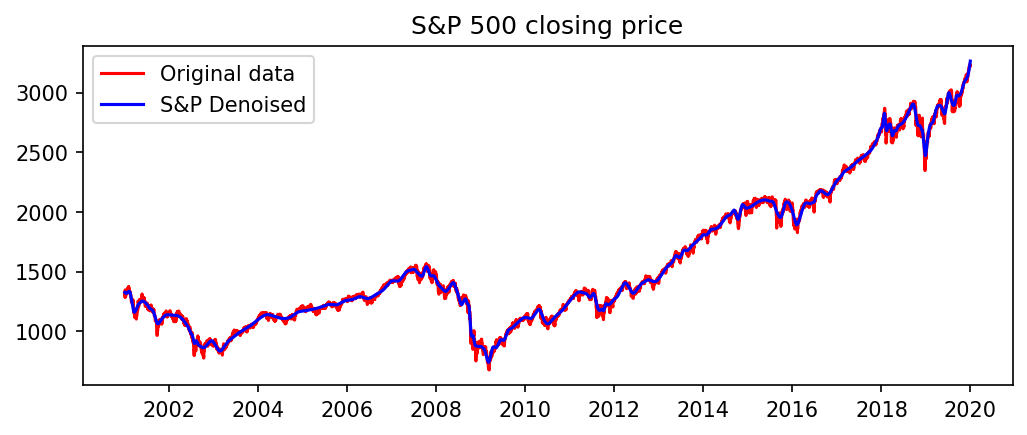

In [ ]:
plt.figure(figsize=(8,3), dpi=150)
plt.plot(df_daily_data['Closing Price'], label='Original data', color='red')
plt.plot(reconstructed_SPX['Closing Price'], label='S&P Denoised', color='blue')
plt.title("S&P 500 closing price")
plt.legend()
plt.show()

---
> **The figures below show the closing price curves before and after denoising using the wavelet transform. By comparing them, it is found that the noise after wavelet transform processing is smaller.**

---



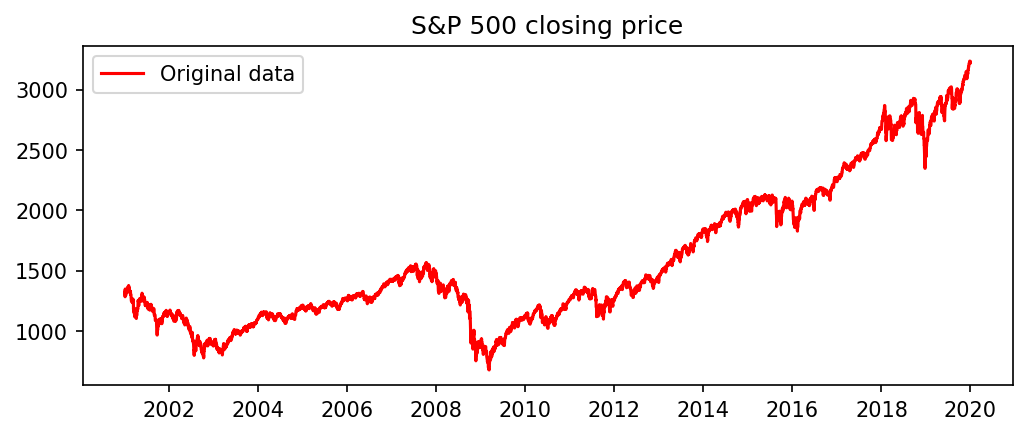

In [ ]:
plt.figure(figsize=(8,3), dpi=150)
plt.plot(df_daily_data['Closing Price'], label='Original data', color='red')
#plt.plot(reconstructed_SPX['closing_price'], label='S&P Denoised', color='blue')
plt.title("S&P 500 closing price")
plt.legend()
plt.show()

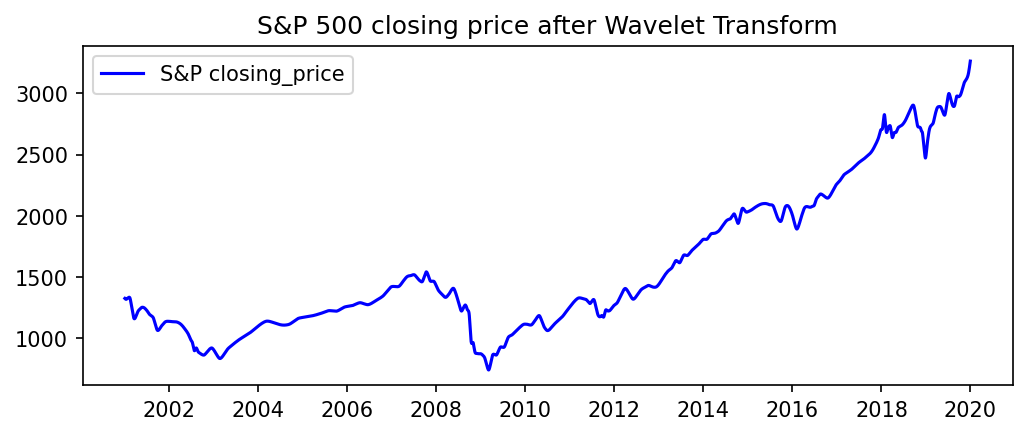

In [ ]:
plt.figure(figsize=(8,3), dpi=150)
#plt.plot(df['closing_price'], label='Original data', color='red')
plt.plot(reconstructed_SPX, label='S&P closing_price', color='blue')
plt.title("S&P 500 closing price after Wavelet Transform")
plt.legend()
plt.show()

**Download S&P 500 open, high, low prices and the volume**

In [ ]:
import datetime as dt

In [ ]:
start = dt.datetime(2000, 12, 31)
end = dt.datetime(2019, 12, 31)

df_SPX_stocks = web.DataReader(['^GSPC'], 'yahoo', start, end)
df_SPX_stocks.columns = ['Ajd Close', 'Close', 'High', 'Low' ,'Open', 'Volume']
df_SPX_stocks

,Ajd Close,Close,High,Low,Open,Volume
Date,,,,,,
2001-01-02,1283.270020,1283.270020,1320.280029,1276.050049,1320.280029,1129400000
2001-01-03,1347.560059,1347.560059,1347.760010,1274.619995,1283.270020,1880700000
2001-01-04,1333.339966,1333.339966,1350.239990,1329.140015,1347.560059,2131000000
2001-01-05,1298.349976,1298.349976,1334.770020,1294.949951,1333.339966,1430800000
2001-01-08,1295.859985,1295.859985,1298.349976,1276.290039,1298.349976,1115500000
...,...,...,...,...,...,...
2019-12-24,3223.379883,3223.379883,3226.429932,3220.510010,3225.449951,1296540000
2019-12-26,3239.909912,3239.909912,3240.080078,3227.199951,3227.199951,2160680000
2019-12-27,3240.020020,3240.020020,3247.929932,3234.370117,3247.229980,2428670000


**Compute technical indicators for trends modeling**

In [ ]:
stock_df = Sdf.retype(df_SPX_stocks)
df_SPX_stocks['rsi']=stock_df['rsi_14']
del df_SPX_stocks['close_-1_s']
del df_SPX_stocks['close_-1_d']
del df_SPX_stocks['rs_14']
del df_SPX_stocks['rsi_14']
del df_SPX_stocks['closepm']
del df_SPX_stocks['closenm']
del df_SPX_stocks['closepm_14_smma']
del df_SPX_stocks['closenm_14_smma']


df_SPX_stocks['CCI']=stock_df['cci']
df_SPX_stocks['STCK%']=stock_df['kdjk']
df_SPX_stocks['ADO'] = (df_SPX_stocks['high'] - df_SPX_stocks['close'])/(df_SPX_stocks['high']-df_SPX_stocks['low'])

In [ ]:
df_SPX_stocks.head()

,ajd close,close,high,low,open,volume,rsi,CCI,STCK%,ADO
Date,,,,,,,,,,
2001-01-02,1283.270020,1283.270020,1320.280029,1276.050049,1320.280029,1129400000,NaN,NaN,38.774568,0.836763
2001-01-03,1347.560059,1347.560059,1347.760010,1274.619995,1283.270020,1880700000,100.000000,66.666667,59.091918,0.002734
2001-01-04,1333.339966,1333.339966,1350.239990,1329.140015,1347.560059,2131000000,80.762337,78.716507,65.278406,0.800950
2001-01-05,1298.349976,1298.349976,1334.770020,1294.949951,1333.339966,1430800000,53.492969,-29.735146,53.979125,0.914615
2001-01-08,1295.859985,1295.859985,1298.349976,1276.290039,1298.349976,1115500000,52.143676,-86.857456,45.348682,0.112874


**Get rid of holidays, weekends ang keep only business days**

In [ ]:
class BankCalendar(AbstractHolidayCalendar):
    rules = [
        Holiday("New Year's Day", month=1, day=1, observance=sunday_to_monday),
        Holiday("Martin Luther King Jr.'s Birthday", month=1, day=1, offset=WeekOfMonth(week=3, weekday=1)),
        Holiday("Washington's Birthday", month=2, day=1, offset=WeekOfMonth(week=3, weekday=1)),
        USMemorialDay,
        Holiday("Independence Day", month=7, day=4, observance=sunday_to_monday),
        USLaborDay,
        USColumbusDay,
        Holiday("Veteran's Day", month=11, day=11, observance=sunday_to_monday),
        USThanksgivingDay,
        Holiday("Christmas Day", month=12, day=25, observance=sunday_to_monday),
    ]

# Keep only bank business days
Bank_business_days = CustomBusinessDay(calendar = BankCalendar())
business_days = pd.date_range('2000-12-31', end = '2019-12-31', freq = Bank_business_days)
df_business_days = pd.DataFrame(business_days, columns = ['Date'])
df_business_days.set_index('Date', inplace = True, drop = True)
df_daily_data = df_daily_data.join(df_business_days, how = 'right')

In [ ]:
df_daily_data = df_daily_data.merge(df_SPX_stocks, how='inner', on='Date')

In [ ]:
df_daily_data

,SPX Index,Vix Index,GDP US,Taux 10 ans US,FDTR Index,Indice CRB,CRB - Métaux,CRB - Industrie de base,CRB - Alimentaire,CRB - Textile,MACD,BSPGCPUS Index,Surprise économique,Or,Chômage US,Confiance des consommateurs US,Inflation US,CPTICHNG Index,Closing Price,ajd close,close,high,low,open,volume,rsi,CCI,STCK%,ADO
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2001-01-02,-2.80,29.99,3.0,4.9150,6.50,222.54,211.24,253.76,183.96,244.15,-15.078643,5.7,-0.218,270.0,3.9,128.55,3.4,79.9609,1283.312160,1283.270020,1283.270020,1320.280029,1276.050049,1320.280029,1129400000,NaN,NaN,38.774568,0.836763
2001-01-03,5.01,26.60,3.0,5.1580,6.00,222.53,210.76,253.53,184.17,244.15,-11.375763,5.7,-0.218,269.3,3.9,128.55,3.4,79.9609,1347.606099,1347.560059,1347.560059,1347.760010,1274.619995,1283.270020,1880700000,100.000000,66.666667,59.091918,0.002734
2001-01-04,-1.06,26.97,3.0,5.0390,6.00,222.80,210.62,253.95,184.29,243.49,-9.479367,5.7,-0.218,268.4,3.9,128.55,3.4,79.9609,1333.321475,1333.339966,1333.339966,1350.239990,1329.140015,1347.560059,2131000000,80.762337,78.716507,65.278406,0.800950
2001-01-05,-2.62,28.67,3.0,4.9310,6.00,223.70,210.83,254.36,185.68,243.43,-10.676785,5.7,-0.218,269.0,3.9,128.55,3.4,79.9609,1298.388452,1298.349976,1298.349976,1334.770020,1294.949951,1333.339966,1430800000,53.492969,-29.735146,53.979125,0.914615
2001-01-08,-0.19,29.84,3.0,4.9560,6.00,224.48,211.59,255.17,186.40,244.80,-11.691893,5.7,-0.218,269.0,3.9,128.55,3.4,79.9609,1295.921514,1295.859985,1295.859985,1298.349976,1276.290039,1298.349976,1115500000,52.143676,-86.857456,45.348682,0.112874
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24,-0.02,12.67,2.1,1.8996,1.75,398.81,757.07,451.23,333.39,280.42,34.643269,18.8,0.138,1499.1,3.5,126.80,2.1,77.5723,3218.999205,3223.379883,3223.379883,3226.429932,3220.510010,3225.449951,1296540000,75.832040,101.064316,94.748484,0.515218
2019-12-26,0.51,12.65,2.1,1.8944,1.75,399.49,758.45,451.60,334.39,280.52,36.152876,18.8,0.138,1509.3,3.5,126.80,2.1,77.5723,3235.416101,3239.909912,3239.909912,3240.080078,3227.199951,3227.199951,2160680000,78.415059,113.069057,96.431116,0.013212
2019-12-27,0.00,13.43,2.1,1.8752,1.75,401.00,758.15,451.65,337.44,280.76,36.932393,18.8,0.138,1513.8,3.5,126.80,2.1,77.5723,3235.416101,3240.020020,3240.020020,3247.929932,3234.370117,3247.229980,2428670000,78.431595,111.731236,93.520222,0.583335


In [ ]:
df_relevant_indicators = df_daily_data[['SPX Index', 'FDTR Index', 'Vix Index', 'GDP US', 'Surprise économique', 'Inflation US', 'Confiance des consommateurs US', 'Taux 10 ans US', 'close', 'volume', 'Chômage US']]
df_relevant_indicators.head(5)

,SPX Index,FDTR Index,Vix Index,GDP US,Surprise économique,Inflation US,Confiance des consommateurs US,Taux 10 ans US,close,volume,Chômage US
Date,,,,,,,,,,,
2001-01-02,-2.80,6.5,29.99,3.0,-0.218,3.4,128.55,4.915,1283.270020,1129400000,3.9
2001-01-03,5.01,6.0,26.60,3.0,-0.218,3.4,128.55,5.158,1347.560059,1880700000,3.9
2001-01-04,-1.06,6.0,26.97,3.0,-0.218,3.4,128.55,5.039,1333.339966,2131000000,3.9
2001-01-05,-2.62,6.0,28.67,3.0,-0.218,3.4,128.55,4.931,1298.349976,1430800000,3.9
2001-01-08,-0.19,6.0,29.84,3.0,-0.218,3.4,128.55,4.956,1295.859985,1115500000,3.9


# **Trends modeling**

In [ ]:
df_trends_indicator = df_daily_data[['close', 'rsi', 'MACD', 'CCI', 'STCK%', 'ADO']]

def ado_stck_macd_trends(data, name):
  indicator = [None]
  for i in range(len(data) - 1):
    if data[name][i+1] > data[name][i]:
      indicator.append(1)
    else:
      indicator.append(0)
  return indicator

df_trends_indicator['ADO_trends'] = ado_stck_macd_trends(df_trends_indicator, 'ADO')
df_trends_indicator['STCK%_trends'] = ado_stck_macd_trends(df_trends_indicator, 'STCK%')
df_trends_indicator['MACD_trends'] = ado_stck_macd_trends(df_trends_indicator, 'MACD')

In [ ]:
df_trends_indicator = df_trends_indicator[1:]
df_trends_indicator.head()

,close,rsi,MACD,CCI,STCK%,ADO,ADO_trends,STCK%_trends,MACD_trends
Date,,,,,,,,,
2001-01-03,1347.560059,100.000000,-11.375763,66.666667,59.091918,0.002734,0.0,1.0,1.0
2001-01-04,1333.339966,80.762337,-9.479367,78.716507,65.278406,0.800950,1.0,1.0,1.0
2001-01-05,1298.349976,53.492969,-10.676785,-29.735146,53.979125,0.914615,1.0,0.0,0.0
2001-01-08,1295.859985,52.143676,-11.691893,-86.857456,45.348682,0.112874,0.0,0.0,0.0
2001-01-09,1300.800049,54.590891,-11.959890,-32.288047,41.772636,0.658622,1.0,0.0,0.0


### **Recall - Precision - F1_score - AUC**

**Recall**, or **sensitivity**, is the rate of true positives, i.e. the proportion of positives that have been correctly identified.

In [ ]:
from sklearn import metrics

In [ ]:
def metrics_classification_report(expected, predicted, trends_model):
  df_metrics_report = pd.DataFrame(columns = [trends_model], index = ['Accuracy', 'F1', 'Recall', 'Precision','Specificity'])
  df_metrics_report[trends_model]['Accuracy'] = metrics.accuracy_score(expected, predicted)
  df_metrics_report[trends_model]['F1'] = metrics.f1_score(expected, predicted)
  df_metrics_report[trends_model]['Precision'] = metrics.precision_score(expected, predicted)
  df_metrics_report[trends_model]['Recall'] = metrics.recall_score(expected, predicted)
  tn, fp, fn, tp = metrics.confusion_matrix(expected, predicted).ravel()
  df_metrics_report[trends_model]['Specificity'] = tn/(fp + tn)
  return df_metrics_report

## **Vector AutoRegressive : VAR**

In [ ]:
df_var = df_relevant_indicators.copy()
del df_var['SPX Index']
df_var.head(4)

,FDTR Index,Vix Index,GDP US,Surprise économique,Inflation US,Confiance des consommateurs US,Taux 10 ans US,close,volume,Chômage US
Date,,,,,,,,,,
2001-01-02,6.5,29.99,3.0,-0.218,3.4,128.55,4.915,1283.270020,1129400000,3.9
2001-01-03,6.0,26.60,3.0,-0.218,3.4,128.55,5.158,1347.560059,1880700000,3.9
2001-01-04,6.0,26.97,3.0,-0.218,3.4,128.55,5.039,1333.339966,2131000000,3.9
2001-01-05,6.0,28.67,3.0,-0.218,3.4,128.55,4.931,1298.349976,1430800000,3.9


### **Stationary**

In [ ]:
def check_stationary(dataframe):
  for column in dataframe.columns:
    stat = adfuller(dataframe[column])
    adf = stat[0]
    pvalue = stat[1]
    print('\033[94m' + f'    Augmented Dickey-Fuller Test on "{column}"', "\n   ", '-'*47)
    print('ADF Statistic: %f' % adf)
    print('p-value: %f' % pvalue)
    print('Critical Values:')
    for key, value in stat[4].items():
      print('\t%s: %.3f' % (key, value))

    if pvalue <= 0.05:
        print(f" => P-Value = {pvalue}. Rejecting Null Hypothesis.")
        print(f" =>  Variable is Stationary.")
    else:
        print(f" => P-Value = {pvalue}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Variable is Non-Stationary.")    

    print('\n')    

In [ ]:
check_stationary(df_var)

    Augmented Dickey-Fuller Test on "FDTR Index" 
    -----------------------------------------------
ADF Statistic: -2.221867
p-value: 0.198405
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
 => P-Value = 0.1984049134909916. Weak evidence to reject the Null Hypothesis.
 => Variable is Non-Stationary.


    Augmented Dickey-Fuller Test on "Vix Index" 
    -----------------------------------------------
ADF Statistic: -4.399836
p-value: 0.000297
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
 => P-Value = 0.0002970315830302128. Rejecting Null Hypothesis.
 =>  Variable is Stationary.


    Augmented Dickey-Fuller Test on "GDP US" 
    -----------------------------------------------
ADF Statistic: -2.278670
p-value: 0.178940
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
 => P-Value = 0.17893968064053045. Weak evidence to reject the Null Hypothesis.
 => Variable is Non-Stationary.


    Augmented Dickey-Fuller Test on "Surprise économique" 
    -----------------------

**Only two series are stationary according to ADF statistical test. US inflation and Vix Index**

In [ ]:
stationary_columns = ['VIX Index', 'Inflation US', "Surprise économique"]
for column in df_var.columns:
  if not column in stationary_columns:
    df_var[column] = df_var[column].diff()

In [ ]:
df_stationnary_var = df_var.dropna()
df_stationnary_var.head(4)

,FDTR Index,Vix Index,GDP US,Surprise économique,Inflation US,Confiance des consommateurs US,Taux 10 ans US,close,volume,Chômage US
Date,,,,,,,,,,
2001-01-03,-0.5,-3.39,0.0,-0.218,3.4,0.0,0.243,64.290039,751300000.0,0.0
2001-01-04,0.0,0.37,0.0,-0.218,3.4,0.0,-0.119,-14.220093,250300000.0,0.0
2001-01-05,0.0,1.70,0.0,-0.218,3.4,0.0,-0.108,-34.989990,-700200000.0,0.0
2001-01-08,0.0,1.17,0.0,-0.218,3.4,0.0,0.025,-2.489990,-315300000.0,0.0


**Check Stationary after differenciating**

In [ ]:
check_stationary(df_stationnary_var)

    Augmented Dickey-Fuller Test on "FDTR Index" 
    -----------------------------------------------
ADF Statistic: -7.678762
p-value: 0.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
 => P-Value = 1.5237011896286878e-11. Rejecting Null Hypothesis.
 =>  Variable is Stationary.


    Augmented Dickey-Fuller Test on "Vix Index" 
    -----------------------------------------------
ADF Statistic: -18.608474
p-value: 0.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
 => P-Value = 2.0661700863630956e-30. Rejecting Null Hypothesis.
 =>  Variable is Stationary.


    Augmented Dickey-Fuller Test on "GDP US" 
    -----------------------------------------------
ADF Statistic: -68.535856
p-value: 0.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 =>  Variable is Stationary.


    Augmented Dickey-Fuller Test on "Surprise économique" 
    -----------------------------------------------
ADF Statistic: -5.719974
p

**The whole dataframe is now stationary**

### **Granger's Causality**

Granger's causality evaluates the influence between time series in a system and determines whether or not they are related. Granger's causality is based on the fact that $X_t$ causes $Y_t$ if the prediction of $Y_t$ conditional on its past values is improved by also taking into account $X_t$ past values. This test helps us understand and know if the information we have about $X_t$ and its past improves the knowledge of $Y_t$.



In [ ]:
from statsmodels.tsa.stattools import grangercausalitytests
def check_causality(dataframe):
  df_causality = pd.DataFrame(np.zeros((len(dataframe.columns), len(dataframe.columns))), columns=dataframe.columns, index=dataframe.columns)
  for column in df_causality.columns:
    for row in df_causality.index:
      causality = grangercausalitytests(dataframe[[row, column]], maxlag=40, verbose=False)
      p_values = [round(causality[i+1][0]['ssr_chi2test'][1],4) for i in range(40)]
      min_p_value = np.min(p_values)
      df_causality.loc[row, column] = min_p_value
      df_causality.columns = [c for c in dataframe.columns]
      df_causality.index = [c for c in dataframe.columns]
  return df_causality    
df_causality = check_causality(df_stationnary_var)  

In [ ]:
df_causality

,FDTR Index,Vix Index,GDP US,Surprise économique,Inflation US,Confiance des consommateurs US,Taux 10 ans US,close,volume,Chômage US
FDTR Index,1.0000,0.0000,0.2644,0.0188,0.0000,0.0026,0.0990,0.0000,0.0052,0.0746
Vix Index,0.0002,1.0000,0.0001,0.0050,0.0002,0.0049,0.0006,0.0000,0.0000,0.0138
GDP US,0.0000,0.0000,1.0000,0.0001,0.0000,0.3946,0.0001,0.0856,0.0022,0.0000
Surprise économique,0.0185,0.0002,0.8357,1.0000,0.5204,0.8062,0.0002,0.0010,0.0020,0.0000
Inflation US,0.0000,0.0000,0.0141,0.0081,1.0000,0.0000,0.0001,0.0000,0.0003,0.5551
Confiance des consommateurs US,0.0000,0.0000,0.8647,0.0000,0.1591,1.0000,0.0001,0.0000,0.0000,0.1643
Taux 10 ans US,0.0350,0.0001,0.1505,0.1018,0.0005,0.0083,1.0000,0.0034,0.0004,0.0917
close,0.0647,0.0000,0.2976,0.2509,0.0094,0.0119,0.0849,1.0000,0.0104,0.0665
volume,0.0383,0.0000,0.0280,0.0483,0.1846,0.0017,0.0001,0.0000,1.0000,0.0000
Chômage US,0.0000,0.0000,0.0103,0.0007,0.0000,0.0356,0.0719,0.0009,0.0074,1.0000


In [ ]:
del df_stationnary_var['GDP US']

**As we can see, all variables are causal for S&P 500 closing price since pvalues are less than 0.05. The stock price is also causal for almost all the variables. We can keep our macroeconomic variables.**

### **Split into training & testing data**

In [ ]:
df_train_var = df_stationnary_var[:int(0.8*(len(df_stationnary_var)))]
df_test_var = df_stationnary_var[int(0.8*(len(df_stationnary_var))):]

In [ ]:
step = len(df_test_var)

In [ ]:
df_train_var.head()

,FDTR Index,Vix Index,Surprise économique,Inflation US,Confiance des consommateurs US,Taux 10 ans US,close,volume,Chômage US
Date,,,,,,,,,
2001-01-03,-0.5,-3.39,-0.218,3.4,0.0,0.243,64.290039,751300000.0,0.0
2001-01-04,0.0,0.37,-0.218,3.4,0.0,-0.119,-14.220093,250300000.0,0.0
2001-01-05,0.0,1.70,-0.218,3.4,0.0,-0.108,-34.989990,-700200000.0,0.0
2001-01-08,0.0,1.17,-0.218,3.4,0.0,0.025,-2.489990,-315300000.0,0.0
2001-01-09,0.0,-1.85,-0.218,3.4,0.0,0.044,4.940063,75800000.0,0.0


### **Optimal order for the VAR model**

**To conduct optimal order search, we will use Information Criterion Akaike (AIC) as a model selection criterion. We select VAR p order based on the best AIC score.**

In [ ]:
from statsmodels.tsa.api import VAR
order_list = [i for i in range(50)]
aic_list = []
var_model = VAR(df_train_var)
for i in order_list:
  compute_aic = var_model.fit(i)
  aic_list.append(compute_aic.aic)

**Let's plot**

In [ ]:
sns.set(rc={'figure.figsize':(20, 7)})

No handles with labels found to put in legend.


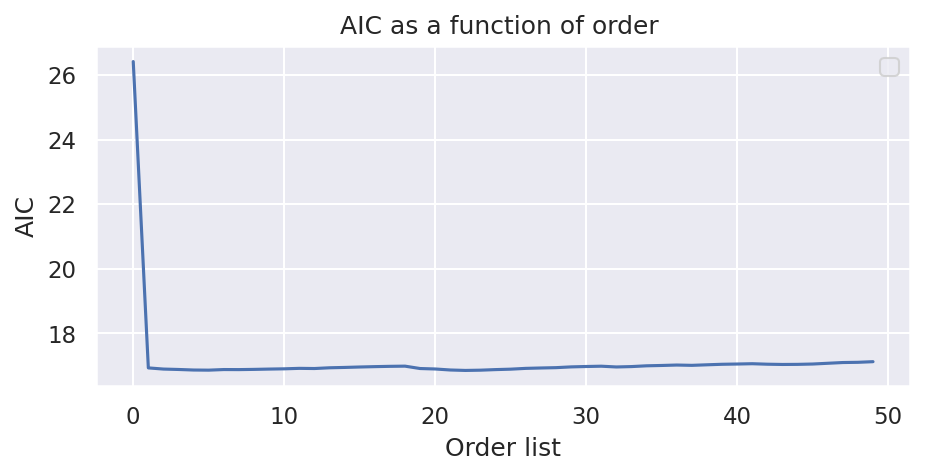

In [ ]:
plt.figure(figsize=(7,3), dpi=150)
plt.plot(order_list, aic_list)
plt.xlabel('Order list')
plt.ylabel('AIC')
plt.legend()
plt.title("AIC as a function of order ")
plt.show()

In [ ]:
x = var_model.select_order(maxlags=40)
x.summary()

,AIC,BIC,FPE,HQIC
0,26.33,26.35,2.735e+11,26.34
1,16.90,17.05*,2.186e+07,16.95*
2,16.86,17.15,2.107e+07,16.97
3,16.85,17.27,2.080e+07,17.00
4,16.83,17.39,2.042e+07,17.03
5,16.83*,17.52,2.031e+07*,17.07
6,16.84,17.67,2.065e+07,17.14
7,16.84,17.80,2.060e+07,17.18
8,16.85,17.95,2.074e+07,17.24
9,16.85,18.09,2.089e+07,17.29


### **Use selected order to train the model**

In [ ]:
fitted_var = var_model.fit(5)
fitted_var.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 10, Jun, 2021
Time:                     12:33:30
--------------------------------------------------------------------
No. of Equations:         9.00000    BIC:                    17.5448
Nobs:                     3758.00    HQIC:                   17.1025
Log likelihood:          -79254.2    FPE:                2.09646e+07
AIC:                      16.8583    Det(Omega_mle):     1.87903e+07
--------------------------------------------------------------------
Results for equation FDTR Index
                                       coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------------------------
const                                     0.000076         0.001254            0.061           0.952
L1.FDTR Index                            -0.001574         0.016428         

### **Forecasting**

In [ ]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(fitted_var.resid)

def adjust(val, length= 6): return str(val).ljust(length)

for col, val in zip(fitted_var.resid.columns, out):
    print(adjust(col), ':', round(val, 2))

FDTR Index : 2.0
Vix Index : 2.0
Surprise économique : 2.0
Inflation US : 2.0
Confiance des consommateurs US : 2.0
Taux 10 ans US : 2.0
close  : 2.0
volume : 2.01
Chômage US : 2.0


In [ ]:
#Forecasting
prediction = fitted_var.forecast(fitted_var.y, steps=12)
df_var_forecast = pd.DataFrame(prediction,  columns=df_test_var.columns + '_pred')
closing_price_var = pd.DataFrame(df_var_forecast['close_pred'])

In [ ]:
closing_price_var

,closing_price_pred
0,1.166341
1,0.571697
2,0.436847
3,0.379052
4,0.383125
5,0.397134
6,0.403074
7,0.405319
8,0.405627
9,0.404004


In [ ]:
df_test_var.head(4)

,Vix Index,GDP US,Taux 10 ans US,FDTR Index,Indice CRB,CRB - Métaux,CRB - Industrie de base,CRB - Alimentaire,CRB - Textile,CRB - Bétail,Chômage US,Confiance des consommateurs US,Inflation US,Or,Surprise économique,CPTICHNG Index,closing_price
Date,,,,,,,,,,,,,,,,,
2014-04-20,0.00,0.0,0.0000,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,1.5,0.0,-0.124,0.0,0.147049
2014-04-21,-0.11,0.0,-0.0064,0.0,-1.35,0.44,0.40,-3.40,-0.08,-0.72,0.0,0.0,1.5,-5.4,-0.124,0.0,0.091448
2014-04-22,-0.06,0.0,-0.0046,0.0,1.23,2.50,1.08,1.40,0.86,0.12,0.0,0.0,1.5,-7.4,-0.124,0.0,0.074280
2014-04-23,0.08,0.0,-0.0118,0.0,0.67,1.64,0.09,1.32,-0.48,0.44,0.0,0.0,1.5,3.6,-0.124,0.0,0.096177


In [ ]:
closing_price_var['closing_price_actual_diff'] = df_test_var['closing_price']
closing_price_var['actual_price'] = reconstructed_SPX['closing_price']['2014-04-20':'2019-12-31']

### **Invert differenciation transformation**

In [ ]:
closing_price_var['predicted_price'] = reconstructed_SPX['closing_price'].iloc[-step-1] + closing_price_var['closing_price_pred'].cumsum()

In [ ]:
closing_price_var

,closing_price_pred,closing_price_actual_diff,actual_price,predicted_price
Date,,,,
2014-04-20,0.175776,0.147049,1681.452975,1681.481702
2014-04-21,0.193476,0.091448,1681.544423,1681.675179
2014-04-22,0.209256,0.074280,1681.618703,1681.884434
2014-04-23,0.224115,0.096177,1681.714880,1682.108549
2014-04-24,0.238342,0.129548,1681.844428,1682.346891
...,...,...,...,...
2019-12-27,0.151916,9.703269,3796.476168,2090.449468
2019-12-28,0.151915,9.779184,3806.255352,2090.601384
2019-12-29,0.151914,9.811335,3816.066687,2090.753298


### **TRENDS**

In [ ]:
var_trends_2 = pd.DataFrame(trends_model2(closing_price_var['predicted_price'], 12, mean_train), columns=['Trends_2'])
var_trends_1 = pd.DataFrame(trends_model1(closing_price_var['predicted_price'],12), columns=['Trends_1'])
#var_trends_1['Trends_1'] = (var_trends_1 > 0)*1 + (var_trends_1 < 0)*(-1)


# **Accuracy**

In [ ]:
var_1_accuracy = compute_accuracy(var_trends_1['Trends_1'], df_trends_model_1['Trends'])
var_2_accuracy = compute_accuracy(var_trends_2['Trends_2'], df_trends_model_2['Trends'])
print('VAR Model 1 trends forecasting accuracy : %f' % var_1_accuracy)
print('--------------------------------------------')
print('VAR Model 2 trends forecasting accuracy : %f' % var_2_accuracy)

VAR Model 1 trends forecasting accuracy : 72.413793
--------------------------------------------
VAR Model 2 trends forecasting accuracy : 69.827586


In [ ]:
metrics.confusion_matrix(df_trends_model_1['Trends'], var_trends_1['Trends_1'])

array([[ 3, 29],
       [ 1, 83]])

## **Rollong Prediction**

In [ ]:
test_len = len(df_test_var)
test_len

941

In [ ]:
df_var1.head(4)

,Vix Index,GDP US,Taux 10 ans US,FDTR Index,Indice CRB,CRB - Métaux,CRB - Industrie de base,CRB - Alimentaire,CRB - Textile,CRB - Bétail,Chômage US,Confiance des consommateurs US,Inflation US,Or,Surprise économique,CPTICHNG Index,closing_price
Date,,,,,,,,,,,,,,,,,
2001-01-01,0.00,0.0,0.002,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,3.4,0.0,-0.218,0.0,-11.542446
2001-01-02,3.14,0.0,-0.199,0.0,-1.45,-2.79,-2.05,-0.78,-1.59,-1.62,0.0,0.0,3.4,-2.0,-0.218,0.0,-11.319035
2001-01-03,-3.39,0.0,0.243,-0.5,-0.01,-0.48,-0.23,0.21,0.00,-0.41,0.0,0.0,3.4,-0.7,-0.218,0.0,-11.124812
2001-01-04,0.37,0.0,-0.119,0.0,0.27,-0.14,0.42,0.12,-0.66,1.96,0.0,0.0,3.4,-0.9,-0.218,0.0,-10.821054


In [ ]:
#del df_var1['Vix Index']
del df_var1['Indice CRB']


In [ ]:
target_snp['closing_price'].tail(12).mean()

1790.2433155391918

In [ ]:
def trends_forecast(var_df, train_size, df_target_price, trends_window):
  n_train = len(var_df[:int(train_size*(len(var_df)))])
  n_test = len(var_df[int(train_size*(len(var_df))):])
  n_trends_window = n_test // trends_window
  predicted_trends_var = {'Average' : [], 'Difference' : []}
  last_window_mean = df_target_price[n_train - trends_window : n_train].mean()
  for i in range(n_trends_window + 1):
    #Define model
    model = VAR(var_df[:n_train + i*trends_window])
    #fit model
    fitted_var = model.fit(32)
    #Forecasting
    prediction_var = fitted_var.forecast(fitted_var.y, steps=trends_window)
    df__forecast = pd.DataFrame(prediction_var, columns=var_df.columns + '_pred')
    var_closing_price = pd.DataFrame(df__forecast['closing_price_pred'])
    var_closing_price['predicted_price'] = df_target_price[trends_window*i + n_train:].iloc[0] + var_closing_price['closing_price_pred'].cumsum()

    predicted_trends_var['Average'].append(trends_model2(var_closing_price['predicted_price'], trends_window, last_window_mean)[0])
    predicted_trends_var['Difference'].append(trends_model1(var_closing_price['predicted_price'], trends_window)[0])
    last_window_mean = var_closing_price['predicted_price'].mean()
  return predicted_trends_var

In [ ]:
df_target_price = reconstructed_SPX['closing_price']
validation_data = pd.DataFrame(df_target_price[int(0.7*(len(df_target_price))):], columns=['closing_price'])

In [ ]:
df_target_price

Date
2000-12-31    1339.121571
2001-01-01    1327.579125
2001-01-02    1316.260090
2001-01-03    1305.135278
2001-01-04    1294.314224
                 ...     
2019-12-27    3796.476168
2019-12-28    3806.255352
2019-12-29    3816.066687
2019-12-30    3825.878129
2019-12-31    3835.643108
Name: closing_price, Length: 6940, dtype: float64

### **Trends_window : 3**

In [ ]:
def confusion_matrix(expected, predicted):
  df_confusion_matrix = pd.DataFrame(data = metrics.confusion_matrix(expected, predicted), columns = ['Actual Positive', 'Actual Negative'], index = ['Predicted Positive', 'Predicted Negative'])
  return df_confusion_matrix

In [ ]:
confusion_matrix(actual_trends_var['Difference'], predicted_trends_var['Difference'])

,Actual Positive,Actual Negative
Predicted Positive,51,10
Predicted Negative,3,110
